<a href="https://colab.research.google.com/github/invtrdan/Machine-Learning/blob/main/Classifying_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Images

* Each input is a grid of pixel values, and each output is a label from a small set of labels.
* Starts with a simple binary linear classifier and finishes with a multi-class neural network classifier.
* Training models on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images.

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

# Load the dataset

from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset. The label for X_train[0] is in Y_train[0], the label for X_test[0] is in Y_test[0], etc.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

np.random.seed(0) # "seed" the random number generator to more easily reproduce the same results.

# Shuffle the order of the *training* examples.
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

4422102/4422102 [==============================] - 0s 0us/step


There are 60,000 instances in `X_train`. Each of these is a grayscale image represented by an 28-by-28 array of grayscale pixel values between 0 and 255 (the larger the value, the lighter the pixel)

In [4]:
# Show the data shapes.
print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)
print("first row of the first image in X_train:\n", X_train[0, 0, :])

X_train.shape: (60000, 28, 28)
Y_train.shape: (60000,)
X_test.shape: (10000, 28, 28)
Y_test.shape: (10000,)
first row of the first image in X_train:
 [  0   0   1   0   0   2   0   0   0   0  65 171 152  53  47  59  62 150
 186  66   0   0   0   0   1   1   0   0]


In [5]:
# Apply linear scaling to pixel values, so they fall between 0 and 1

# Pixel values range from 0 to 255. To normalize the data, we just need to
# divide all values by 255.
#
# NOTE: only run this once, or else you will divide your data by 255 multiple times.
X_train = X_train / 255
X_test = X_test / 255

print("First row of the first image in X_train, normalized:\n", X_train[0, 0, :])

First row of the first image in X_train, normalized:
 [0.         0.         0.00392157 0.         0.         0.00784314
 0.         0.         0.         0.         0.25490196 0.67058824
 0.59607843 0.20784314 0.18431373 0.23137255 0.24313725 0.58823529
 0.72941176 0.25882353 0.         0.         0.         0.
 0.00392157 0.00392157 0.         0.        ]


Treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

Fashion MNIST images have one of 10 possible labels (shown above). Since the labels are indices 0-9, let's keep a list of (string) names for convenience.

In [6]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Show the first 5 training labels.
print('First 5 label values:', Y_train[0:5])
print('Mapped to their names:', [label_names[i] for i in Y_train[0:5]])

First 5 label values: [0 2 6 5 2]
Mapped to their names: ['t-shirt', 'pullover', 'shirt', 'sandal', 'pullover']


Use the `imshow` function to look at the first few images in the training set.

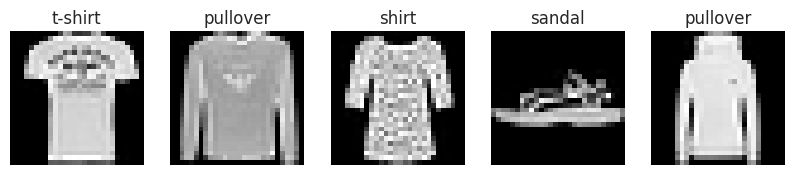

In [7]:
# Create a figure with subplots. This returns a list of object handles in axs
# which we can use populate the plots.
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_train[i]
  label = Y_train[i]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')  # imshow renders a 2D grid
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

Display the first 5 images for each class in a 10 x 5 grid.

In [9]:
def plot_images(imgs, figsize=(5, 5)):
  fig, axs = plt.subplots(1, 5, figsize=figsize)

  for img, ax in zip(imgs, axs.flatten()):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
  plt.show()

Class 0:


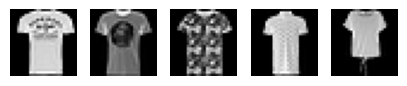

Class 1:


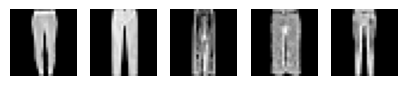

Class 2:


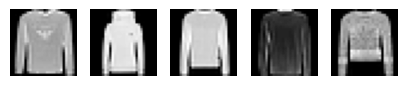

Class 3:


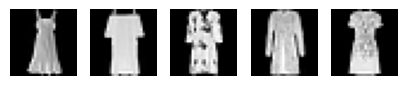

Class 4:


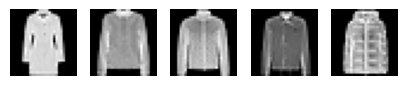

Class 5:


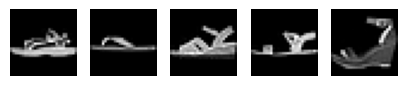

Class 6:


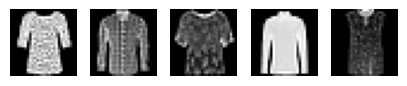

Class 7:


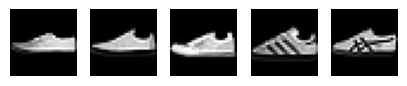

Class 8:


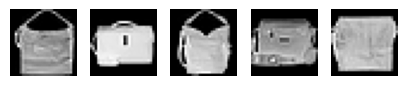

Class 9:


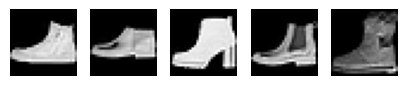

In [10]:
num_classes = 10
for class_num in range(num_classes):
    # Find indices of images that belong to the current class
    indices = np.where(Y_train == class_num)[0]
    # Select the first 5 images for the current class
    imgs = X_train[indices[:5]]
    # Plot images
    print(f"Class {class_num}:")
    plot_images(imgs)

# Sneaker Classifier
* Binary Classification
* Train a sneaker classifier, using sneaker images as positive examples (" 𝑦=1 " <-> "sneaker" <-> class 7) and all other images as negative examples (" 𝑦=0 " <-> "non-sneaker" <-> classes 0, 1, 2, 3, 4, 5, 6, 8, 9).
* Once we've trained a model, it will produce predictions $\hat{y}$, the probability that an input image $x$ is a sneaker.

## Data Preprocessing
* Prepare the data for binary classification task.
* Map sneaker image labels to 1 (the positive class) and all other image labels to 0 (the negative class).

In [11]:
# Make copies of the original labels.
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Update labels: 1 for sneaker images; 0 for the rest.
# Note that a boolean array is created when Y_train_binary != 7 is evaluated.
Y_train_binary[Y_train_binary != 7] = 0.0
Y_train_binary[Y_train_binary == 7] = 1.0
Y_test_binary[Y_test_binary != 7] = 0.0
Y_test_binary[Y_test_binary == 7] = 1.0

1.   Find all sneaker images in `X_train` and compute the mean and standard deviation of the center pixel value across all **sneaker** images. The center pixel is located at position [14, 14].

In [12]:
# Find indices of all sneaker images
sneaker_indices = np.where(Y_train_binary == 1.0)[0]

# Extract sneaker images based on identified indices
sneaker_images = X_train[sneaker_indices]

# Extract the center pixel value (at position [14, 14]) from each sneaker image
center_pixels = sneaker_images[:, 14, 14]

# Compute the mean and standard deviation of the center pixel values
mean_center_pixel = np.mean(center_pixels)
std_dev_center_pixel = np.std(center_pixels)

print("Mean of center pixel values across all sneaker images:", mean_center_pixel)
print("Standard deviation of center pixel values across all sneaker images:", std_dev_center_pixel)

Mean of center pixel values across all sneaker images: 0.6279993464052288
Standard deviation of center pixel values across all sneaker images: 0.2420192071490903


2.   Find all non-sneaker images in `X_train` and compute the mean and standard deviation of the center pixel values across all **non-sneaker** images. The center pixel is located at position [14, 14].

In [13]:
# Filter for non-sneaker images using the binary labels
non_sneaker_indices = np.where(Y_train_binary == 0)[0]
non_sneaker_images = X_train[non_sneaker_indices]

# Extract the center pixel ([14, 14]) from each non-sneaker image
center_pixels_non_sneakers = non_sneaker_images[:, 14, 14]

# Compute the mean and standard deviation of the center pixel values for non-sneakers
mean_center_pixel_non_sneakers = np.mean(center_pixels_non_sneakers)
std_dev_center_pixel_non_sneakers = np.std(center_pixels_non_sneakers)

print("Mean of center pixel value across all non-sneaker images:", mean_center_pixel_non_sneakers)
print("Standard deviation of center pixel value across all non-sneaker images:", std_dev_center_pixel_non_sneakers)

Mean of center pixel value across all non-sneaker images: 0.5365848220769789
Standard deviation of center pixel value across all non-sneaker images: 0.31489747339469804


3. Repeat 1 and 2 for the pixel located at positon [3, 14].

In [14]:
# Filter for sneaker images
sneaker_indices = np.where(Y_train_binary == 1)[0]
sneaker_images = X_train[sneaker_indices]

# Filter for non-sneaker images
non_sneaker_indices = np.where(Y_train_binary == 0)[0]
non_sneaker_images = X_train[non_sneaker_indices]

# Extract the pixel at position [3, 14] from each sneaker image
pixel_sneakers = sneaker_images[:, 3, 14]

# Extract the pixel at position [3, 14] from each non-sneaker image
pixel_non_sneakers = non_sneaker_images[:, 3, 14]

# Compute the mean and standard deviation for the pixel values at [3, 14] among sneakers
mean_pixel_sneakers = np.mean(pixel_sneakers)
std_dev_pixel_sneakers = np.std(pixel_sneakers)

# Compute the mean and standard deviation for the pixel values at [3, 14] among non-sneakers
mean_pixel_non_sneakers = np.mean(pixel_non_sneakers)
std_dev_pixel_non_sneakers = np.std(pixel_non_sneakers)

print("Sneaker images, pixel [3, 14] - Mean:", mean_pixel_sneakers, "Std Dev:", std_dev_pixel_sneakers)
print("Non-sneaker images, pixel [3, 14] - Mean:", mean_pixel_non_sneakers, "Std Dev:", std_dev_pixel_non_sneakers)

Sneaker images, pixel [3, 14] - Mean: 0.0012503267973856208 Std Dev: 0.02829347092206015
Non-sneaker images, pixel [3, 14] - Mean: 0.46437283950617286 Std Dev: 0.3678363831207802


## Baseline

In [15]:
print('Number of sneaker images in training set:', (Y_train_binary == 1).sum())
print('Number of non-sneaker images in training set:', (Y_train_binary == 0).sum())

Number of sneaker images in training set: 6000
Number of non-sneaker images in training set: 54000


In [19]:
import numpy as np

def log_loss(Y_true, Y_pred):
    """
    Compute the Log Loss (binary cross-entropy) metric.

    Parameters:
    - Y_true: numpy array, true binary labels
    - Y_pred: numpy array, predicted probabilities

    Returns:
    - log_loss: float, the Log Loss metric
    """
    eps = 1e-15
    Y_pred = np.clip(Y_pred, eps, 1 - eps)  # Clip predictions to avoid log(0) error
    log_loss = -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))
    return log_loss

# Baseline predicted probability
p_baseline = 0.1

# Use the log_loss function to evaluate the baseline on both the train and test data
log_loss_train = log_loss(Y_train_binary, np.full(Y_train_binary.shape, p_baseline))
log_loss_test = log_loss(Y_test_binary, np.full(Y_test_binary.shape, p_baseline))

print("Log Loss on Training Data:", log_loss_train)
print("Log Loss on Testing Data:", log_loss_test)


Log Loss on Training Data: 0.32508297339144815
Log Loss on Testing Data: 0.3250829733914482


## Binary Logistic Regression Classification
Using Tensorflow/Keras to build logistic regression model

In [21]:
def build_model(input_shape, learning_rate=0.1):
  """Build a TF logistic regression model using Keras.

  Args:
    input_shape: The shape of the model's input.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # Reset TF and random seed (for reproducible results).
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Use the Keras Sequential API as before.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our 28x28 images
  # and flatten them into vectors of size 784.
  model.add(keras.layers.Flatten(input_shape=input_shape))

  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation='sigmoid'         # apply the sigmoid function!
  ))

  # We'll use mini-batch SGD and can specify the batch size later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Compile the model.
  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=[metrics.binary_accuracy])

  return model

# Build the model. Notice that we are passing the shape of our images to
# the model, as Keras needs to know the dimension of the input.
model = build_model(input_shape=X_train[0].shape)

# Make a prediction for five inputs.
print(model.predict(X_train[0:5]))

1/1 [==============================] - 0s 194ms/step
[[0.77302724]
 [0.6796593 ]
 [0.6983938 ]
 [0.45114595]
 [0.63809603]]


## Training
* using 10% of the training data as a validation split



In [22]:
model = build_model(input_shape=X_train[0].shape, learning_rate=0.1)

# Fit the model.
history = model.fit(
  x = X_train,          # our binary training examples
  y = Y_train_binary,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
844/844 [==============================] - 4s 4ms/step - loss: 0.0914 - binary_accuracy: 0.9648 - val_loss: 0.0778 - val_binary_accuracy: 0.9703
Epoch 2/5
844/844 [==============================] - 2s 3ms/step - loss: 0.0668 - binary_accuracy: 0.9763 - val_loss: 0.0685 - val_binary_accuracy: 0.9732
Epoch 3/5
844/844 [==============================] - 3s 4ms/step - loss: 0.0603 - binary_accuracy: 0.9784 - val_loss: 0.0643 - val_binary_accuracy: 0.9743
Epoch 4/5
844/844 [==============================] - 8s 10ms/step - loss: 0.0567 - binary_accuracy: 0.9796 - val_loss: 0.0619 - val_binary_accuracy: 0.9762
Epoch 5/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0544 - binary_accuracy: 0.9804 - val_loss: 0.0603 - val_binary_accuracy: 0.9763


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.091381,0.964759,0.077767,0.970333
1,0.066846,0.976278,0.068501,0.973167
2,0.060318,0.978407,0.064261,0.974333
3,0.056650,0.979648,0.061866,0.976167
4,0.054418,0.980352,0.060271,0.976333


## Inference
Use the trained model to predict probabilities for the test data. We can use `predict` to run *inference*. The probabilities output by the model will be the probability of the positive class.

In [23]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_predictions = model.predict(X_test).flatten()
print(test_predictions.shape)
print(test_predictions)

313/313 [==============================] - 1s 2ms/step
(10000,)
[1.0108979e-01 3.3299627e-11 2.6425297e-04 ... 4.1876637e-04 1.0662113e-03
 1.2638475e-01]


## Evaluation

To turn probabilities into binary predictions, we need to choose a classification threshold. A probability greater than or equal to threshold indicates class sneaker, while a value less than the threshold indicates class non-sneaker. Once we have binary predictions, we can evaluate performance with some different metrics.
A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.
A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.
Using these, we can construct a confusion matrix, a table that summarizes performance using these 4 result categories.

In [25]:
def evaluate_thresholds(y_true, y_pred_probs, thresholds):
    results = []
    for threshold in thresholds:
        # Convert predicted probabilities to binary predictions based on the threshold
        y_pred = (y_pred_probs >= threshold).astype(int)

        # Calculate True Positives, True Negatives, False Positives, False Negatives
        TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
        TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
        FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
        FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))

        # Calculate Accuracy, Precision, and Recall
        accuracy = (TP + TN) / len(y_true)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # Store results
        results.append({
            'Threshold': threshold,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall
        })

    return results

# Define the thresholds
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

results = evaluate_thresholds(Y_test_binary, test_predictions, thresholds)
for result in results:
    print(result)

{'Threshold': 0.1, 'TP': 984, 'TN': 8548, 'FP': 452, 'FN': 16, 'Accuracy': 0.9532, 'Precision': 0.6852367688022284, 'Recall': 0.984}
{'Threshold': 0.3, 'TP': 943, 'TN': 8834, 'FP': 166, 'FN': 57, 'Accuracy': 0.9777, 'Precision': 0.8503155996393147, 'Recall': 0.943}
{'Threshold': 0.5, 'TP': 887, 'TN': 8902, 'FP': 98, 'FN': 113, 'Accuracy': 0.9789, 'Precision': 0.9005076142131979, 'Recall': 0.887}
{'Threshold': 0.7, 'TP': 796, 'TN': 8956, 'FP': 44, 'FN': 204, 'Accuracy': 0.9752, 'Precision': 0.9476190476190476, 'Recall': 0.796}
{'Threshold': 0.9, 'TP': 571, 'TN': 8988, 'FP': 12, 'FN': 429, 'Accuracy': 0.9559, 'Precision': 0.9794168096054888, 'Recall': 0.571}


## Analyze Classification Mistakes
Our model is not perfect. Regardless of the classification threshold we choose, it misclassifies some images. Let's take a look at some of the images that our model misclassified.

1. Display 5 images that were erroneously classified as sneaker (threshold = 0.5).

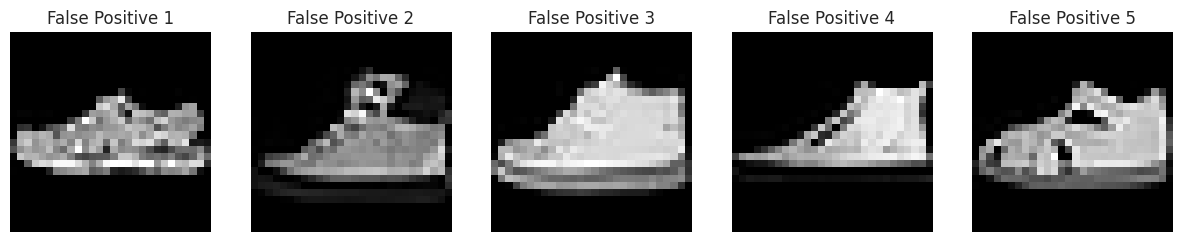

In [26]:
# Convert predictions to binary based on the threshold of 0.5
binary_predictions = (test_predictions >= 0.5).astype(int)

# Find indices of false positives (where prediction is 1 but true label is 0)
false_positives_indices = np.where((binary_predictions == 1) & (Y_test_binary == 0))[0][:5]

# Plot the first 5 false positive images
plt.figure(figsize=(15, 3))
for i, index in enumerate(false_positives_indices):
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns, ith+1 subplot
    plt.imshow(X_test[index], cmap='gray')
    plt.title(f'False Positive {i+1}')
    plt.axis('off')
plt.show()

2. Display 5 images that were erroneously classified as non-sneaker (threshold = 0.5).

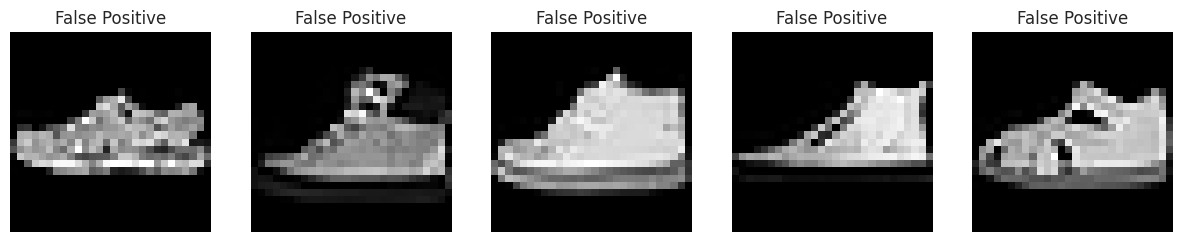

In [27]:
# Predictions with threshold = 0.5
predictions = (test_predictions >= 0.5).astype(int)

# Indices where the predicted class is sneaker but the true class is not sneaker
false_positives = np.where((predictions == 1) & (Y_test_binary == 0))[0]

# Plot the first 5 incorrectly classified as sneaker
plt.figure(figsize=(15, 3))
for i, index in enumerate(false_positives[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[index], cmap='gray')
    plt.title('False Positive')
    plt.axis('off')
plt.show()

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def build_softmax_model(input_shape, n_classes, learning_rate=0.1):
  """Build a TF softmax regression model using Keras.

  Args:
    input_shape: The shape of the model's input.
    n_classes: Number of classes in the dataset.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=input_shape))
  model.add(keras.layers.Dense(
      units=n_classes,  # Set the units to the number of classes
      activation='softmax'  # Use softmax activation for multi-class classification
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy',  # Use categorical crossentropy for loss
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

# Load and preprocess the dataset
# Assuming the following variables are your dataset split into features and labels:
# (X_train, Y_train), (X_test, Y_test) = <your code to load the dataset>
# Make sure to normalize and preprocess your dataset here.

# Number of unique classes in the dataset
n_classes = len(label_names)

# One-hot encode the labels
Y_train_one_hot = to_categorical(Y_train, num_classes=n_classes)
Y_test_one_hot = to_categorical(Y_test, num_classes=n_classes)

# Build the softmax model
softmax_model = build_softmax_model(input_shape=X_train[0].shape, n_classes=n_classes, learning_rate=0.1)

# Fit the model
history = softmax_model.fit(
  x=X_train,
  y=Y_train_one_hot,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1
)

# Evaluate the model
test_loss, test_accuracy = softmax_model.evaluate(X_test, Y_test_one_hot, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


Epoch 1/5
844/844 [==============================] - 3s 3ms/step - loss: 0.6370 - accuracy: 0.7862 - val_loss: 0.5492 - val_accuracy: 0.8130
Epoch 2/5
844/844 [==============================] - 3s 4ms/step - loss: 0.4953 - accuracy: 0.8309 - val_loss: 0.5080 - val_accuracy: 0.8253
Epoch 3/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4670 - accuracy: 0.8416 - val_loss: 0.4857 - val_accuracy: 0.8317
Epoch 4/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4512 - accuracy: 0.8455 - val_loss: 0.5229 - val_accuracy: 0.8212
Epoch 5/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4415 - accuracy: 0.8489 - val_loss: 0.4748 - val_accuracy: 0.8402
Test loss: 0.4749773442745209
Test accuracy: 0.8327000141143799


In [33]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
softmax_test_predictions = np.argmax(softmax_model.predict(X_test), axis=-1)
print(softmax_test_predictions)

313/313 [==============================] - 3s 9ms/step
[9 2 1 ... 8 1 5]


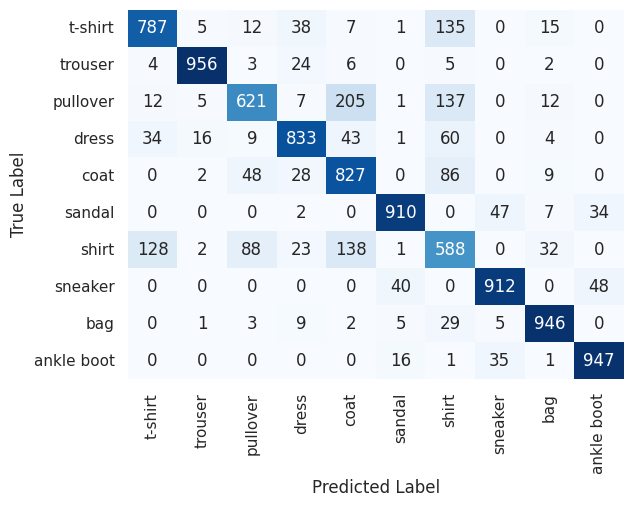

In [34]:
# Create a confusion matrix as a 2D array.
softmax_confusion_matrix = tf.math.confusion_matrix(Y_test,
                                                    softmax_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(softmax_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [37]:
import tensorflow as tf
from tensorflow import keras

def build_ffnn_softmax_model(input_shape, n_classes, learning_rate=0.1):
    """Build a TF feed-forward neural network model using Keras.

    Args:
      input_shape: The shape of the model's input.
      n_classes: Number of classes in dataset
      learning_rate: The desired learning rate for SGD.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = keras.Sequential()

    # Input to neural network using keras.layers.Flatten()
    model.add(keras.layers.Flatten(input_shape=input_shape))

    # keras.layers.Dense() layer w/ 128 units and ReLU activation
    model.add(keras.layers.Dense(128, activation='relu'))

    # Another keras.layers.Dense() layer w/ 128 units and ReLU activation
    model.add(keras.layers.Dense(128, activation='relu'))

    # Final output layer using keras.layers.Dense()
    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

ffnn_softmax_model = build_ffnn_softmax_model(
    X_train[0].shape, len(label_names), 0.1)

ffnn_softmax_history = ffnn_softmax_model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

ffnn_softmax_history = pd.DataFrame(ffnn_softmax_history.history)
display(ffnn_softmax_history)

# Print a summary of the model's layers and parameters.
ffnn_softmax_model.summary()


Epoch 1/5
844/844 [==============================] - 5s 5ms/step - loss: 0.5960 - accuracy: 0.7879 - val_loss: 0.4692 - val_accuracy: 0.8315
Epoch 2/5
844/844 [==============================] - 4s 5ms/step - loss: 0.4152 - accuracy: 0.8499 - val_loss: 0.4348 - val_accuracy: 0.8400
Epoch 3/5
844/844 [==============================] - 5s 5ms/step - loss: 0.3719 - accuracy: 0.8637 - val_loss: 0.3914 - val_accuracy: 0.8543
Epoch 4/5
844/844 [==============================] - 4s 5ms/step - loss: 0.3451 - accuracy: 0.8714 - val_loss: 0.3796 - val_accuracy: 0.8622
Epoch 5/5
844/844 [==============================] - 5s 5ms/step - loss: 0.3247 - accuracy: 0.8804 - val_loss: 0.3626 - val_accuracy: 0.8658


,loss,accuracy,val_loss,val_accuracy
0,0.596044,0.787889,0.469226,0.831500
1,0.415211,0.849870,0.434841,0.840000
2,0.371924,0.863722,0.391433,0.854333
3,0.345065,0.871370,0.379639,0.862167
4,0.324716,0.880426,0.362571,0.865833


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


313/313 [==============================] - 4s 10ms/step


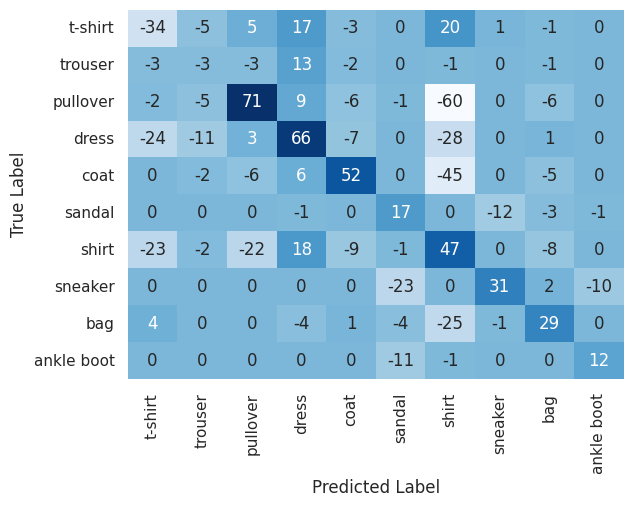

In [38]:
ffnn_softmax_test_predictions = np.argmax(
    ffnn_softmax_model.predict(X_test), axis=-1)

# Create a confusion matrix as a 2D array.
ffnn_softmax_confusion_matrix = tf.math.confusion_matrix(
    Y_test, ffnn_softmax_test_predictions)

# Use a heatmap plot to display it.
diff_confusion_matrix = ffnn_softmax_confusion_matrix - softmax_confusion_matrix
ax = sns.heatmap(diff_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

* Diagonal Values: The diagonal values in the confusion matrix of differences represent the change in the number of true predictions for each class by the neural network model compared to the baseline model. A positive value indicates that the neural network model correctly predicted more instances of that class than the baseline model, while a negative value suggests it predicted fewer.
* Off-Diagonal Values: The off-diagonal values show the change in the number of specific misclassifications between two classes. For example, a value at position (i, j) (where i ≠ j) indicates how the count of misclassifications of class i as class j has changed in the neural network model compared to the baseline model. A positive value means that the neural network model made more mistakes of this specific kind than the baseline model, while a negative value means it made fewer.

In [42]:
# Convert the confusion matrix to float to support np.nan
diff_confusion_matrix_np = diff_confusion_matrix.numpy().astype(float)

# Mask the diagonal to focus on off-diagonal values
np.fill_diagonal(diff_confusion_matrix_np, np.nan)

# Find the index of the most negative value in the off-diagonal entries
min_value_index = np.unravel_index(np.nanargmin(diff_confusion_matrix_np), diff_confusion_matrix_np.shape)

# Retrieve the class names for the most improved confused pair
most_improved_confusion = (label_names[min_value_index[0]], label_names[min_value_index[1]])

print("Most improved confused pair:", most_improved_confusion)


Most improved confused pair: ('pullover', 'shirt')
